<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Домашнее задание № 10
## <center> Реализация градиентного бустинга

В этом задании мы реализуем алгоритм градиентного бустинга в довольно общем виде, один и тот же класс будет описывать бинарный классификатор, при обучении которого минимизируется логистическая фунцкция потерь, и 2 регрессора, минимизирующих среднеквадратическую ошибку MSE и [RMSLE](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError). Это даст представление о том, что с помощью градиентного бустинга можно оптимизировать произвольные дифференцируемые функции потерь, а также что бустинг адаптируется под разные задачи. [Веб-форма](https://goo.gl/forms/mMUhGSDiOHJI9NHN2) для ответов.

Версию алгоритма берем из [статьи](https://habrahabr.ru/company/ods/blog/327250/#klassicheskiy-gbm-algoritm-friedman-a) (см. псевдокод), но с двумя упрощениями:
- инициализация – средним значением вектора $\large y$, то есть $\large \hat{f_0} = \frac{1}{n}\sum_{i=1}^{n}y_i$
- шаг градиентного спуска (то же что и вес очередного базового алгоритма в композиции) постоянный: $\large \rho_t = const$

Соответствие обозначений в псевдокоде и в классе `GradientBoosting`, который мы сейчас напишем:
- $\large \{x_i, y_i\}_{i = 1,\ldots n}$ или `X`, `y` – обучающая выборка
- $\large L(y,f)$ или `objective` – функция потерь
- $\large \frac{\partial L(y_i,f(x_i))}{\partial f(x_i)}$ или `objective_grad` – градиент функции потерь
- $М$ или `n_estimators` – число итераций бустинга
- $\large h(x,\theta)$ или `DecisionionTreeRegressor` – базовый алгоритм, дерево решений для регрессии
- $\large \theta$ – гиперпараметры деревьев, мы рассмотрим только `max_depth` и `random_state`
- $\large \rho_t$ или `learning_rate` – коэффициент, с которым  $\large h_t(x,\theta)$ входит в композицию, $t=1,\ldots,M$

## Вычисление градиентов log_loss, MSE и RMSLE

Для начала классика – возьмем ручку и бумажку и посчитаем градиенты функций потерь:

$$log\_loss(y, p) = -y\log p - (1 - y)\log (1 - p) = -\sum_{i=1}^{n}y_i\log p_i + (1 - y_i)\log (1 - p_i)$$

$$MSE(y, p) = \frac{1}{n}(y - p)^T(y - p) = \frac{1}{n}\sum_{i=1}^{n}(y_i - p_i)^2$$

$$RMSLE(y, p) = \sqrt{\frac{1}{n} (\log (p + 1) - \log (y + 1))^T(\log (p + 1) - \log (y + 1))} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(\log (p_i + 1) - \log (y_i + 1))^2}$$

Здесь $y$ и $p$ – это **векторы** истинных ответов и прогнозов соответственно.
`log_loss` взяли как в  `sklearn` – для случая меток целевого класса 0 и 1, а не -1 и 1, как описано в статье (только не усреднили, т.е. нет деления на число объектов $n$, в `sklearn` это соответствует значению аргумента `normalize=False` функции `log_loss`).

<font color='red'>Вопрос 1.</font> Какова формула градиента функции `MSE`?
 1. $(p - y) \hspace{5cm}$ 3. $2(p - y)$
 <br><br>
 2. $\frac{2}{n}(y - p) \hspace{4.7cm}$ 4. $\frac{2}{n}(p - y)$
 
 

<font color='red'>Вопрос 2.</font> Какова формула градиента функции `log_loss`?
 1. $\large \frac{y - p}{y(1 - y)} \hspace{5.2cm}$ 3. $\large \frac{p - y}{p(1 - p)}$
 <br><br>
 2. $\large \frac{y - p}{p(1 - p)}\hspace{5.2cm}$ 4. $\large \frac{p - y}{y(1 - y)}$
 <br><br>
 *Примечание:* деление на вектор – покомпонентное, например $\frac{1}{p} = (\frac{1}{p_1}, \ldots \frac{1}{p_n})^T$

<font color='red'>Вопрос 3.</font> Какова формула градиента функции `RMSLE`?
 1. $\frac{1}{n} (p + 1) RMSLE^{-1}(y, p) \log \frac{p+1}{y+1} \hspace{5cm}$ 3. $[n (y + 1) RMSLE(y, p)]^{-1} \log \frac{p+1}{y+1} $
 <br><br>
 2. $[n (p + 1) RMSLE(y, p)]^{-1} \log \frac{p+1}{y+1} \hspace{5cm}$ 4. $\frac{1}{n} \frac{y+1}{(p + 1)} RMSLE^{-1}(y, p) \log \frac{p+1}{y+1}$

## Реализация алгоритма

Напишем класс `GradientBoosting`. Детали:
- класс наследуется от `sklearn.base.BaseEstimator`;
- конструктор принимает параметры `loss` – название фунцкии потерь, которая будет оптимизироваться (`log_loss`, `mse` (по умолчанию) или `rmsle`), `n_estimators` – число деревьев (т.е. число итераций бустинга, по умолчанию – 10), `learning_rate` – шаг градиентного спуска (по умолчанию $10^{-2}$), `max_depth` – ограничение на максимальную глубину деревьев (по умолчанию 3) и `random_state` – сид генерации псевдослучайных чисел, нужен только для деревьев (по умолчанию 17);
- в зависимости от переданного значения `loss` инициализируются `objective` и `objective_grad`. Для `MSE` берем `sklearn.metrics.mean_squared_error`, для `log_loss` – `sklearn.metrics.log_loss` (без нормализации, то есть на число объектов не надо делить, формула дана выше), а `RMSLE` и градиенты всех трех функций надо реализовать самостоятельно. При подсчете градиентов не выкидывайте константы типа двойки или $n$;
- в реализациях градиентов `log_loss` и `rmsle` будет покомпонентное деление на вектора. Чтобы избежать деление на 0, предварительно замените значения, меньшие $10^{-5}$, на $10^{-5}$. Но только там, где необходимо. Например, в случае вычисления $\frac{y}{p}$ замены делаем только в векторе $p$;
- также в конструкторе создаются списки `loss_by_iter_` и `residuals_by_iter_` для отлаживания работы алгоритма и `trees_` – для хранения обученных деревьев;
- класс имеет методы `fit`, `predict` и `predict_proba`
- метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), а возвращает текущий экземпляр класса `GradientBoosting`, т.е. `self`. Основная логика, конечно же, реализуется здесь. На каждой итерации текущее значение функции потерь записывается в `loss_by_iter_`, значение антиградиента (то что в статье названо псевдо-остатками) – в `residuals_by_iter_` (можно в конструктор добавить флаг `debug=False` и добавлять значения антиградиента только при включенном флаге). Также обученное дерево добавляется в список `trees_`;
- метод `predict_proba` возвращает линейную комбинацию прогнозов деревьев. Не забудем тут и про начальное приближение. В случае регрессии название метода будет не очень удачным, но оставим так, чтоб не писать отдельно классификатор и регрессор. В случае классификации к ответу применяется $\sigma$-преобразование. В реализации $\sigma$-функции замените значения аргумента, превышающие по модулю 100, на -100 или +100 в зависимости от знака (чтоб избежать underflow & overflow);
- метод `predict` в случае регрессии возвращает линейную комбинацию прогнозов деревьев (+ начальное приближение), то есть то же, что и `predict_proba`. В случае классификации метод `predict` задействует метод `predict_proba` и возвращает вектор из 0 и 1, полученный сравнением предсказанных вероятностей с некоторым порогом, при котором максимизируется доля правильных ответов на обучающей выборке. Здесь хорошо было бы решить одномерную задачу оптимизации, но для полной воспроизводимости давайте выбирать порог из `np.linspace(0.01, 1.01, 100)`.


In [90]:
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [112]:
def without_zeros(arr):
    return np.vectorize(lambda e: e if abs(e) > 1e-5 else 1e-5)(arr)

def log_loss_grad(y, p):
    return np.divide((p - y), without_zeros(np.multiply(p, 1 - p)))

def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

def mse_grad(y, p):
    return 2 * (p - y) / len(y)

def rmsle(y, p):
    return np.sqrt(np.sum(np.square(np.log(p + 1) - np.log(y + 1))) / len(y))

def rmsle_grad(y, p):
    return np.multiply(
        np.divide(1, without_zeros(len(y) * (p + 1) * rmsle(y, p))),
        np.log(np.divide(p + 1, without_zeros(y + 1)))
    )

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from functools import partial
import itertools
from sklearn.tree import DecisionTreeRegressor

class GradientBoosting(BaseEstimator):

    def __init__(self, loss='mse', n_estimators=10, learning_rate=1e-2, max_depth=3, random_state=17):
        self.loss = loss
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        if self.loss == 'mse':
            self.objective = mean_squared_error
            self.objective_grad = mse_grad
        elif self.loss == 'log_loss':
            self.objective = partial(log_loss, normalize=False)
            self.objective_grad = log_loss_grad
        elif self.loss == 'rmsle':
            self.objective = rmsle
            self.objective_grad = rmsle_grad
        self.loss_by_iter_ = []
        self.residuals_by_iter_ = []
        self.trees_ = []
    
    def fit(self, X, y):
        self.f0 = y.mean()
        f_hat = np.repeat(self.f0, len(y)).reshape(-1, 1)
        for iter_t in range(self.n_estimators):
            r_t = -1 * self.objective_grad(y, f_hat)
            self.residuals_by_iter_.append(r_t)
            tree_t = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state).fit(X, r_t)
            self.trees_.append(tree_t)
            f_hat = f_hat + self.learning_rate * tree_t.predict(X).reshape(-1, 1)
            self.loss_by_iter_.append(self.objective(y, f_hat))
        if self.loss == 'log_loss':
            probas = sigma(f_hat)
            self.threshold = 0.01
            best_accuracy = 0
            for threshold in np.linspace(0.01, 1, 100):
                labels = np.vectorize(lambda prob: 1 if prob >= threshold else 0)(probas)
                accuracy = accuracy_score(y, labels)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    self.threshold = threshold
        return self
    
    def predict_proba(self, X):
        f_hat = np.repeat(self.f0, X.shape[0]).reshape(-1, 1)
        for tree_t in self.trees_:
            f_hat = f_hat + self.learning_rate * tree_t.predict(X).reshape(-1, 1)
        if self.loss == 'log_loss':
            result = sigma(f_hat)
        else:
            result = f_hat
        return result
    
    def predict(self, X):
        if self.loss == 'log_loss':
            result = np.vectorize(lambda prob: 1 if prob >= self.threshold else 0)(self.predict_proba(X))
        else:
            result = predict_proba(X)
        return result

## Регрессия с игрушечным примером

In [39]:
X_regr_toy = np.arange(7).reshape(-1, 1)
y_regr_toy = ((X_regr_toy - 3) ** 2).astype('float64')

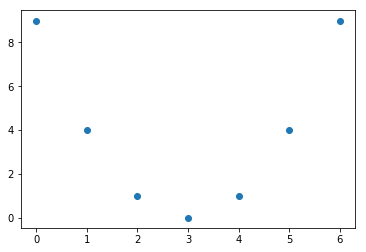

In [40]:
plt.scatter(X_regr_toy, y_regr_toy);

Обучите регрессор `GradientBoosting` с функцией потерь `MSE` и параметрами `learning_rate`=0.1,  `max_depth`=3 – 200 итераций. Посмотрите на изменение функции потерь по итерациям бустинга. Можно также посмотреть на приближение и остатки на первых нескольких итерациях, как это делалось в статье.

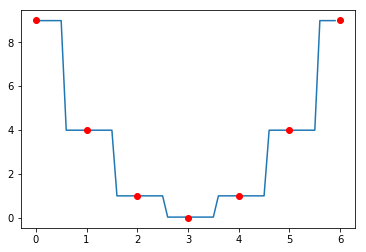

In [44]:
gb = GradientBoosting(n_estimators=200, learning_rate=0.1, max_depth=3)
gb.fit(X_regr_toy, y_regr_toy)
X_check = np.arange(0, 6, 0.1).reshape(-1, 1)
y_check = gb.predict_proba(X_check)

#y_check
plt.plot(X_check, y_check)
plt.plot(X_regr_toy, y_regr_toy, 'ro')
plt.show()

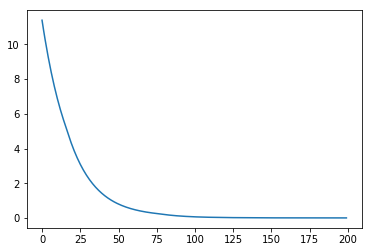

In [45]:
plt.plot(gb.loss_by_iter_)
plt.show()

Обучите регрессор `GradientBoosting` с теми же параметрами, но функцию потерь измените на `RMSLE`. Посмотрите на те же картинки. 

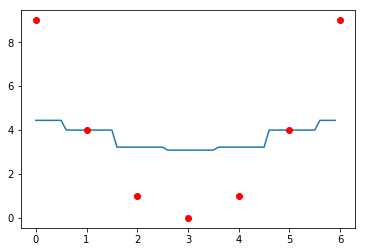

In [46]:
gb = GradientBoosting(loss='rmsle', n_estimators=200, learning_rate=0.1, max_depth=3)
gb.fit(X_regr_toy, y_regr_toy)
X_check = np.arange(0, 6, 0.1).reshape(-1, 1)
y_check = gb.predict_proba(X_check)

#y_check
plt.plot(X_check, y_check)
plt.plot(X_regr_toy, y_regr_toy, 'ro')
plt.show()

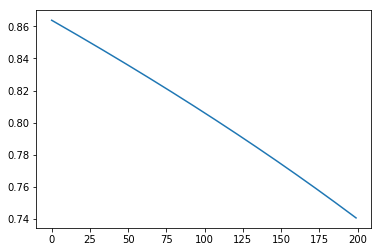

In [47]:
plt.plot(gb.loss_by_iter_)
plt.show()

## Классификация с игрушечным примером

In [101]:
X_clf_toy = np.c_[np.arange(7), (np.arange(7) - 3) ** 2]
y_clf_toy = np.array([0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)

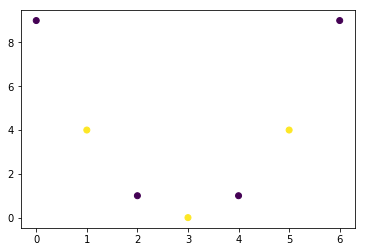

In [102]:
plt.scatter(X_clf_toy[:, 0], X_clf_toy[:, 1], c=y_clf_toy);

Обучите классификатор `GradientBoosting` с функцией потерь `log_loss` и параметрами `learning_rate`=0.05,  `max_depth`=3 – 10 итераций. Посмотрите на изменение функции потерь по итерациям бустинга. Можно также посмотреть на приближение и остатки на первых нескольких итерациях, как это делалось в статье.



<font color='red'>Вопрос 4.</font> Посчитайте предсказанные вероятности отнесения к классу +1 для всех 7 объектов игрушечной выборки. Каковы 2 уникальных значения в полученном векторе?
1. 0.42 и 0.77
2. 0.36 и 0.82
3. 0.48 и 0.53
4. **0.46 и 0.75**

In [103]:
gb = GradientBoosting(loss='log_loss', n_estimators=10, learning_rate=0.05, max_depth=3)
gb.fit(X_clf_toy, y_clf_toy)
gb.predict_proba(X_clf_toy)


#x1 = np.linspace(0, 7, 10).reshape(-1, 1)
#x2 = np.linspace(0, 9, 10).reshape(-1, 1)

#X_check = np.concatenate((x1, x2), axis=1)

#y_check = gb.predict_proba(cartesian(x1, x2))
#x1_m, x2_m = np.meshgrid(x1, x2)

#plt.contourf(x1_m, x2_m, y_check.reshape(10, 10))
#plt.colorbar()  
#plt.show()

array([ 0.45813842,  0.7523411 ,  0.45813842,  0.7523411 ,  0.45813842,
        0.7523411 ,  0.45813842])

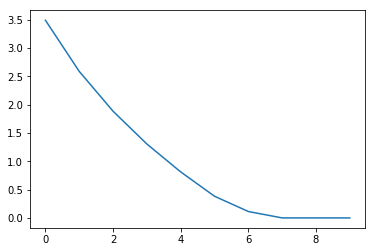

In [52]:
plt.plot(gb.loss_by_iter_)
plt.show()

## Регрессия с UCI boston

In [53]:
boston = load_boston()
X, y = boston.data, boston.target

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

- Обучите регрессор `GradientBoosting` с функцией потерь `MSE` и параметрами `learning_rate`=3,  `max_depth`=10 – 300 итераций
- Посмотрите на изменение функции потерь по итерациям бустинга
- Сделайте прогнозы для отложенной выборки
- Постройте распределение ответов `y_test` на отложенной выборке и наложите на него распределение ответов бустинга `test_pred`. Используйте метод `hist` из `matplotlib.pyplot` с параметром `bins=15`

<font color='red'>Вопрос 5.</font> Выберите верное утверждение про гистограммы:
1. Ответы бустинга в среднем завышены на 10 
2. **В бине, в который попадает медиана ответов на тестовой выборке (`numpy.median(y_test)`), больше значений из вектора прогнозов `test_pred`, чем из вектора ответов `y_test`**
3. **Бустинг иногда прогнозирует значения, сильно выпадающие за диапазон изменения ответов `y_test`**

In [66]:
gb = GradientBoosting(n_estimators=300, learning_rate=3, max_depth=10)
gb.fit(X_train, y_train.reshape(-1, 1))
test_pred = gb.predict(X_test)

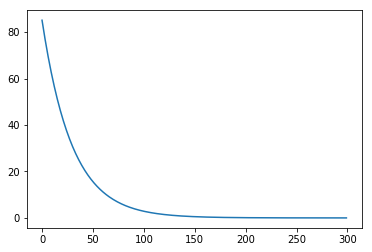

In [67]:
plt.plot(gb.loss_by_iter_)
plt.show()

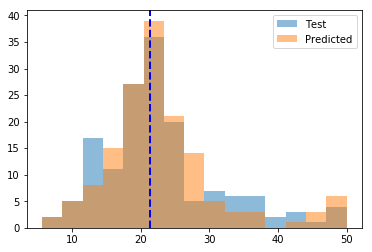

In [77]:
from matplotlib import pyplot

pyplot.hist(y_test, 15, range=(test_pred.min(), y_test.max()), alpha=0.5, label='Test')
pyplot.hist(test_pred, 15, range=(test_pred.min(), y_test.max()), alpha=0.5, label='Predicted')
pyplot.legend(loc='upper right')
pyplot.axvline(np.median(y_test), color='b', linestyle='dashed', linewidth=2)
pyplot.show()

## Классификация с UCI breast cancer

In [78]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

Обучите классификатор `GradientBoosting` с функцией потерь `log_loss` и параметрами `learning_rate`=0.01,  `max_depth`=3 – 200 итераций. Посмотрите на изменение функции потерь по итерациям бустинга. Сделайте прогнозы для отложенной выборки – как предсказанные вероятности отнесения к классу +1, так и бинарные прогнозы. Посчитайте ROC AUC для прогноза в виде вероятностей и долю правильных ответов для прогноза в виде меток классов.

<font color='red'>Вопрос 6.</font> Каковы получаются ROC AUC и доля правильных ответов на отложенной выборке `(X_test, y_test)`?
1. **0.99 и 0.97**
2. 1 и 0.97
3. 0.98 и 0.96
4. 0.97 и 0.95

In [113]:
from sklearn.metrics import roc_auc_score

gb = GradientBoosting(loss='log_loss', n_estimators=200, learning_rate=0.01, max_depth=3)
gb.fit(X_train, y_train.reshape(-1, 1))
test_pred = gb.predict(X_test)
test_proba_pred = gb.predict_proba(X_test)

print(roc_auc_score(y_test, test_proba_pred))
print(accuracy_score(y_test, test_pred))

0.987555886736
0.976608187135


In [114]:
np.linspace(0.01, 1.01, 100)

array([ 0.01      ,  0.02010101,  0.03020202,  0.04030303,  0.05040404,
        0.06050505,  0.07060606,  0.08070707,  0.09080808,  0.10090909,
        0.1110101 ,  0.12111111,  0.13121212,  0.14131313,  0.15141414,
        0.16151515,  0.17161616,  0.18171717,  0.19181818,  0.20191919,
        0.2120202 ,  0.22212121,  0.23222222,  0.24232323,  0.25242424,
        0.26252525,  0.27262626,  0.28272727,  0.29282828,  0.30292929,
        0.3130303 ,  0.32313131,  0.33323232,  0.34333333,  0.35343434,
        0.36353535,  0.37363636,  0.38373737,  0.39383838,  0.40393939,
        0.4140404 ,  0.42414141,  0.43424242,  0.44434343,  0.45444444,
        0.46454545,  0.47464646,  0.48474747,  0.49484848,  0.50494949,
        0.51505051,  0.52515152,  0.53525253,  0.54535354,  0.55545455,
        0.56555556,  0.57565657,  0.58575758,  0.59585859,  0.6059596 ,
        0.61606061,  0.62616162,  0.63626263,  0.64636364,  0.65646465,
        0.66656566,  0.67666667,  0.68676768,  0.69686869,  0.70